In [1]:
#Loading relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score,make_scorer
from sklearn.model_selection import GridSearchCV

#Loading the dataset
df = pd.read_csv("Final_CPS_dataset(30-04-2024_new).csv")
df.head()
print(df.shape)

(304814, 20)


In [2]:
X = df[[
   'age','race', 'sex', 'region_recoded', 'marst', 'nativity', 'classwkr_recoded','annhrs', 'metro', 'wkswork1', 'ft', 'uhrswork', 
    'occupation_category_1990', 'industry_category_1990', 'educ99_lbl_recode', 'bpl_category'
]]

y = df['incWage_2023_inflated']


# Split the data into training and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=107)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=1/8, random_state=107)  # 10% of total data for validation

### Base performance of the regression models

In [17]:
linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

linear_y_pred = linear_model.predict(X_test)

linear_mse = mean_squared_error(y_test, linear_y_pred)
linear_rmse = np.sqrt(linear_mse)
linear_r_squared = r2_score(y_test, linear_y_pred)

print("Base Linear Regression model:")
print("Root Mean Squared Error (RMSE) on the testing set:", linear_rmse)
print("R-squared on the testing set:", linear_r_squared)

xgb_model = XGBRegressor(random_state=107)

xgb_model.fit(X_train, y_train)

xgb_y_pred = xgb_model.predict(X_test)

xgb_mse = mean_squared_error(y_test, xgb_y_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r_squared = r2_score(y_test, xgb_y_pred)

print("\nBase XGBoost Regression model:")
print("Root Mean Squared Error (RMSE) on the testing set:", xgb_rmse)
print("R-squared on the testing set:", xgb_r_squared)

rf_model = RandomForestRegressor(random_state=107)

rf_model.fit(X_train, y_train)

rf_y_pred = rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r_squared = r2_score(y_test, rf_y_pred)

print("\nBase Random Forest Regression model:")
print("Root Mean Squared Error (RMSE) on the testing set:", rf_rmse)
print("R-squared on the testing set:", rf_r_squared)

Base Linear Regression model:
Root Mean Squared Error (RMSE) on the testing set: 25009.872495672567
R-squared on the testing set: 0.3868501859471857

Base XGBoost Regression model:
Root Mean Squared Error (RMSE) on the testing set: 22194.626190595867
R-squared on the testing set: 0.5171198918075116

Base Random Forest Regression model:
Root Mean Squared Error (RMSE) on the testing set: 23629.27539995714
R-squared on the testing set: 0.4526760485652237


### Hyperparameter Tuning XGBoost

In [18]:

# Define the hyperparameter grid for XGBoost

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

param_grid = {
    'learning_rate': [0.15, 0.2, 0.25],
    'n_estimators': [200, 300, 500], # higher values for n_estimator can be indication of overfitting
    'max_depth': [5,6,7],
    'min_child_weight': [2,4,6],
    'colsample_bytree': [0.5, 0.8],
}

model = XGBRegressor(random_state=107)

# Create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring=rmse_scorer,
)

grid_search.fit(X_train, y_train)

# Print the best hyperparameters found by Grid Search
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Retrieve the best model from the grid search
best_model = grid_search.best_estimator_

test_predictions = best_model.predict(X_test)

test_rmse = rmse(y_test, test_predictions)

print("RMSE on test set: ", test_rmse)

Best Hyperparameters: {'colsample_bytree': 0.5, 'learning_rate': 0.15, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 200}
Best Score: -21924.18123766763
RMSE on test set:  22082.478741712897


#### Saving the GridSearch Results of the XGBoost Model

In [19]:

results_dict = {
    'param_learning_rate': grid_search.cv_results_['param_learning_rate'],
    'param_n_estimators': grid_search.cv_results_['param_n_estimators'],
    'param_max_depth': grid_search.cv_results_['param_max_depth'],
    'param_min_child_weight': grid_search.cv_results_['param_min_child_weight'],
    'param_colsample_bytree': grid_search.cv_results_['param_colsample_bytree'],
    'mean_test_score': -grid_search.cv_results_['mean_test_score']
}

# Convert to DataFrame
df_results = pd.DataFrame(results_dict)

# Save to CSV
df_results.to_csv('(30-04-2024)_grid_search_results_xgb.csv', index=False)


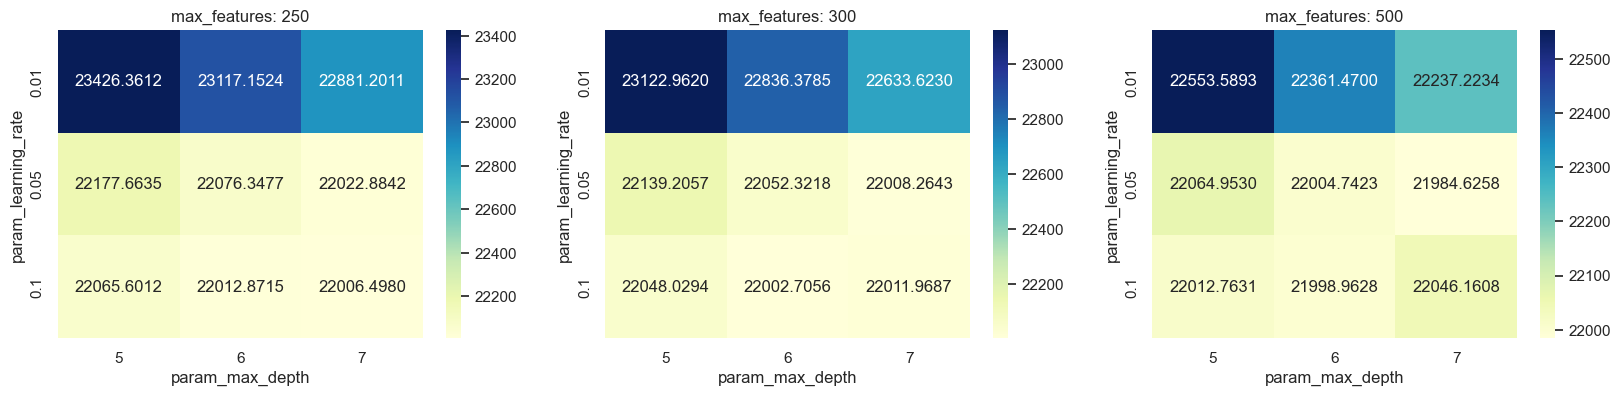

In [15]:
# Create DF of GridSearch results
df_results_xgb = pd.read_csv('(28-04-2024)_grid_search_results_xgb.csv')

def plot_tuning_results(df_val):
    df_temp = df_val[:][df_val.param_n_estimators == 250].sort_values(by=['param_learning_rate'])
    df_none = df_temp[:][df_temp.param_n_estimators == 250].sort_values(by=['param_learning_rate'])
    df_sqrt = df_val[:][df_val.param_n_estimators == 300].sort_values(by=['param_learning_rate'])
    df_log2 = df_val[:][df_val.param_n_estimators == 500].sort_values(by=['param_learning_rate'])


     # Define a function to handle the aggregation of values, ensuring we get the lowest RMSE
    def min_rmse(values):
        return np.min(values)

    pivot1 = df_none.pivot_table(index='param_learning_rate', columns='param_max_depth', values='mean_test_score', aggfunc=min_rmse)
    pivot2 = df_sqrt.pivot_table(index='param_learning_rate', columns='param_max_depth', values='mean_test_score', aggfunc=min_rmse)
    pivot3 = df_log2.pivot_table(index='param_learning_rate', columns='param_max_depth', values='mean_test_score', aggfunc=min_rmse)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

    sns.heatmap(pivot1, annot=True, fmt=".4f", ax=ax1, cmap="YlGnBu", )
    sns.heatmap(pivot2, annot=True, fmt=".4f", ax=ax2, cmap="YlGnBu", )
    sns.heatmap(pivot3, annot=True, fmt=".4f", ax=ax3, cmap="YlGnBu", )
    
    ax1.set_title("max_features: 250")
    ax2.set_title("max_features: 300")
    ax3.set_title("max_features: 500")


plot_tuning_results(df_results_xgb)


### Hyperparameter Tuning Random Forest

In [20]:
# GridSearch for Random Forest
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

model = RandomForestRegressor(random_state=107)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring=rmse_scorer,
)

grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Retrieve the best model from the grid search
best_model = grid_search.best_estimator_

test_predictions = best_model.predict(X_test)

# Calculate RMSE on the test set
test_rmse = rmse(y_test, test_predictions)

# Print RMSE on the test set
print("RMSE on test set: ", test_rmse)


Best Hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
Best Score: -22246.45675630999
RMSE on test set:  22345.702815998364


#### Saving the GridSearch Results of the Random Forest Model

In [21]:

results_dict = {
    'param_n_estimators': grid_search.cv_results_['param_n_estimators'],
    'param_max_depth': grid_search.cv_results_['param_max_depth'],
    'param_min_samples_split': grid_search.cv_results_['param_min_samples_split'],
    'param_min_samples_leaf': grid_search.cv_results_['param_min_samples_leaf'],
    'param_max_features': grid_search.cv_results_['param_max_features'],
    'mean_test_score': -grid_search.cv_results_['mean_test_score']
}

df_results = pd.DataFrame(results_dict)

# Save to CSV
df_results.to_csv('(30-04-2024)_grid_search_results_rf.csv', index=False)


In [126]:
df_results_rf = pd.read_csv('grid_search_results_rf.csv')

# Replacing the nan for the max_depth parameter to 1.0 (Default)
df_results_rf.replace(np.nan, 1.0, inplace=True)
df_results_rf.head()

,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,mean_test_score
0,100,1.0,2,1,1.0,23514.459564
1,150,1.0,2,1,1.0,23474.620639
2,200,1.0,2,1,1.0,23453.476057
3,100,1.0,5,1,1.0,23171.696063
4,150,1.0,5,1,1.0,23138.131823


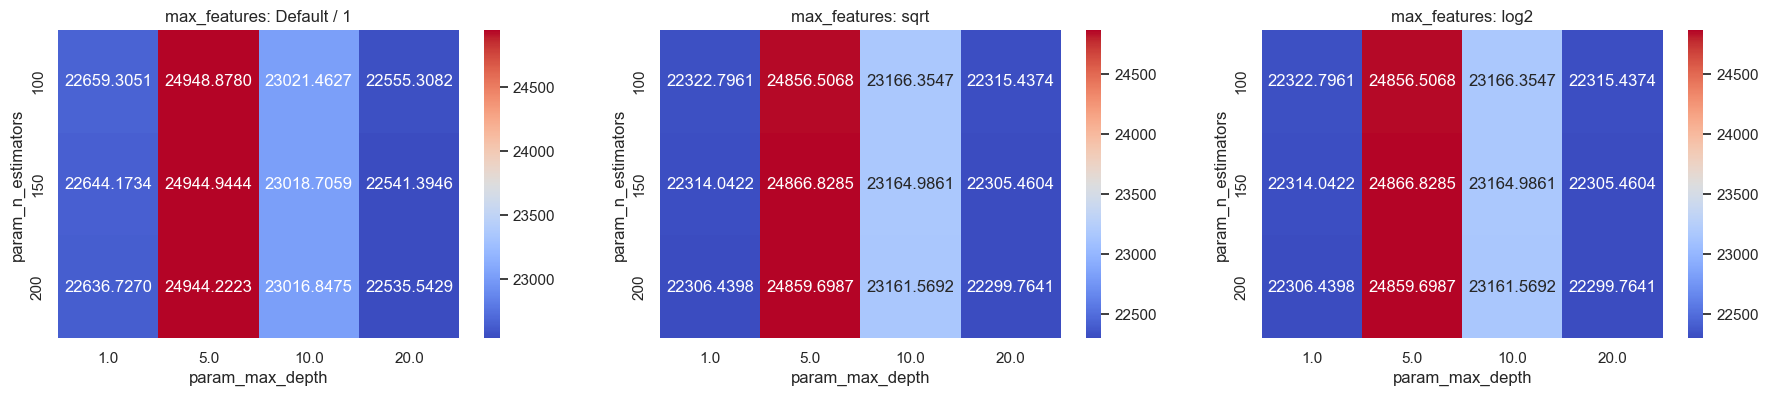

In [127]:
def plot_tuning_results(df_val):
    df_temp = df_val[:][df_val.param_max_features != 'sqrt'].sort_values(by=['param_n_estimators'])
    df_none = df_temp[:][df_temp.param_max_features != 'log2'].sort_values(by=['param_n_estimators'])
    df_sqrt = df_val[:][df_val.param_max_features == 'sqrt'].sort_values(by=['param_n_estimators'])
    df_log2 = df_val[:][df_val.param_max_features == 'log2'].sort_values(by=['param_n_estimators'])

    # Define a function to handle the aggregation of values, ensuring we get the lowest RMSE
    def min_rmse(values):
        return np.min(values)

    pivot1 = df_none.pivot_table(index='param_n_estimators', columns='param_max_depth', values='mean_test_score', aggfunc=min_rmse)
    pivot2 = df_sqrt.pivot_table(index='param_n_estimators', columns='param_max_depth', values='mean_test_score', aggfunc=min_rmse)
    pivot3 = df_log2.pivot_table(index='param_n_estimators', columns='param_max_depth', values='mean_test_score', aggfunc=min_rmse)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 4))

    sns.heatmap(pivot1, annot=True, fmt=".4f", ax=ax1, cmap="coolwarm", )
    sns.heatmap(pivot2, annot=True, fmt=".4f", ax=ax2, cmap="coolwarm", )
    sns.heatmap(pivot3, annot=True, fmt=".4f", ax=ax3, cmap="coolwarm", )
    
    ax1.set_title("max_features: Default / 1")
    ax2.set_title("max_features: sqrt")
    ax3.set_title("max_features: log2")

plot_tuning_results(df_results_rf)
plt.savefig("Grid_search_results_Random_Forest_best_score_22299.764.jpg", dpi = 300,  bbox_inches='tight')


### Training Linear Regression, XGBoost & Random Forest on Training Data with Best Parameters According to GridSearch

In [128]:

linear_model = LinearRegression()

# Fit the linear model 
linear_model.fit(X_train, y_train)


linear_y_pred = linear_model.predict(X_test)

linear_mse = mean_squared_error(y_test, linear_y_pred)
linear_rmse = np.sqrt(linear_mse)
linear_r_squared = r2_score(y_test, linear_y_pred)

print("Linear Regression:")
print("Root Mean Squared Error (RMSE) on the testing set:", linear_rmse)
print("R-squared on the testing set:", linear_r_squared)

xgb_model = XGBRegressor(learning_rate=0.15, n_estimators=200, max_depth=7, min_child_weight=2, colsample_bytree=0.5, random_state=107)

# Fit the XGBoost model
xgb_model.fit(X_train, y_train)


xgb_y_pred = xgb_model.predict(X_test)


xgb_mse = mean_squared_error(y_test, xgb_y_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r_squared = r2_score(y_test, xgb_y_pred)

print("\nXGBoost Regression:")
print("Root Mean Squared Error (RMSE) on the testing set:", xgb_rmse)
print("R-squared on the testing set:", xgb_r_squared)

rf_model = RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2, min_samples_split=10, n_estimators=500, random_state=107)

# Fit the Random Forest model
rf_model.fit(X_train, y_train)

rf_y_pred = rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r_squared = r2_score(y_test, rf_y_pred)

print("\nRandom Forest Regression:")
print("Root Mean Squared Error (RMSE) on the testing set:", rf_rmse)
print("R-squared on the testing set:", rf_r_squared)


Linear Regression:
Root Mean Squared Error (RMSE) on the testing set: 24830.073172753346
R-squared on the testing set: 0.3698668920308198

XGBoost Regression:
Root Mean Squared Error (RMSE) on the testing set: 21963.51044075527
R-squared on the testing set: 0.5069626624190187

Random Forest Regression:
Root Mean Squared Error (RMSE) on the testing set: 22260.676766689026
R-squared on the testing set: 0.4935308148552223


### Training Linear Regression, XGBoost & Random Forest on Combined Training & Validation Set with Best Parameters According to GridSearch

In [3]:
#Trained on all training data (Train + Val)

linear_model_full = LinearRegression()

# Fit the linear model on the training data
linear_model_full.fit(X_train_val, y_train_val)

linear_y_pred_full = linear_model_full.predict(X_test)

linear_mse_full = mean_squared_error(y_test, linear_y_pred_full)
linear_rmse_full = np.sqrt(linear_mse_full)
linear_r_squared_full = r2_score(y_test, linear_y_pred_full)

print("Linear Regression Full Data:")
print("Root Mean Squared Error (RMSE) on the testing set:", linear_rmse_full)
print("R-squared on the testing set:", linear_r_squared_full)

xgb_model_full = XGBRegressor(learning_rate=0.15, n_estimators=200, max_depth=7, min_child_weight=2, colsample_bytree=0.5, random_state=107)

# Fit the XGBoost model 
xgb_model_full.fit(X_train_val, y_train_val)

xgb_y_pred_full = xgb_model_full.predict(X_test)

xgb_mse_full = mean_squared_error(y_test, xgb_y_pred_full)
xgb_rmse_full = np.sqrt(xgb_mse_full)
xgb_r_squared_full = r2_score(y_test, xgb_y_pred_full)

print("\nXGBoost Regression Full training Data:")
print("Root Mean Squared Error (RMSE) on the testing set:", xgb_rmse_full)
print("R-squared on the testing set:", xgb_r_squared_full)

rf_model_full = RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2, min_samples_split=10, n_estimators=500, random_state=107)

# Fit the Random Forest model
rf_model_full.fit(X_train_val, y_train_val)

rf_y_pred_full = rf_model_full.predict(X_test)

rf_mse_full = mean_squared_error(y_test, rf_y_pred_full)
rf_rmse_full = np.sqrt(rf_mse_full)
rf_r_squared_full = r2_score(y_test, rf_y_pred_full)

print("\nRandom Forest Regression Full Data:")
print("Root Mean Squared Error (RMSE) on the testing set:", rf_rmse_full)
print("R-squared on the testing set:", rf_r_squared_full)


Linear Regression Full Data:
Root Mean Squared Error (RMSE) on the testing set: 25009.580838610294
R-squared on the testing set: 0.38686448657433237

XGBoost Regression Full training Data:
Root Mean Squared Error (RMSE) on the testing set: 22055.495919303645
R-squared on the testing set: 0.5231549262233578

Random Forest Regression Full Data:
Root Mean Squared Error (RMSE) on the testing set: 22311.62650787387
R-squared on the testing set: 0.5120154093628801
